In [1]:
!pip install pytorch-pretrained-bert
!pip install transformers

     |████████████████████████████████| 133kB 3.9MB/s 
     |████████████████████████████████| 133kB 16.8MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 7.5MB 40.0MB/s 
ERROR: botocore 1.20.77 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 2.3MB 4.0MB/s 
     |████████████████████████████████| 3.3MB 37.9MB/s 
     |████████████████████████████████| 901kB 34.3MB/s 


# Import BioBERT

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

--2021-05-21 15:54:11--  https://docs.google.com/uc?export=download&confirm=avI6&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD
Resolving docs.google.com (docs.google.com)... 108.177.12.139, 108.177.12.138, 108.177.12.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/1bjk3rr5k3mvqmg6jvg41aeq67hsm40m/qlk48le7127ntv77u7s1bugsvqpnujj7/1621612425000/13799006341648886493/08477970927115493933Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download [following]
--2021-05-21 15:54:11--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/1bjk3rr5k3mvqmg6jvg41aeq67hsm40m/qlk48le7127ntv77u7s1bugsvqpnujj7/1621612425000/13799006341648886493/08477970927115493933Z/1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD?e=download
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connectin

In [4]:
!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [5]:
!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

2021-05-21 15:54:23.815187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shap

# Config

In [6]:
import transformers
from pytorch_pretrained_bert import BertTokenizer

train_batch_size = 8
valid_batch_size = 4

epochs = 12
base_model_path = "/content/biobert_v1.1_pubmed"
model_path = "/content/biobert_appli_model.bin"
training_file = "/content/training_metabolite_sep_check.csv"
tokenizer = transformers.BertTokenizer.from_pretrained(
    base_model_path,
    do_lower_case=True
)

# DataSet

In [7]:
import torch

class EntityDataset:
    def __init__(self, texts, tags, max_len):
        # texts: [["hi", ",", "my", "name", "is" ...], ["hello , ..."]...]
        # tags: [[1 2 3 4 1 5],[...]...]
        self.texts = texts
        self.tags = tags
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]  # item: ["hi", ",", "my", "name", "is" ...]
        tags = self.tags[item]

        ids = []
        target_tag = []

        for i, s in enumerate(text):  # enumerate(text): [(0, "hi"), (1, ","), (2, "my"), ...]
            inputs = tokenizer.encode(
                s,
                add_special_tokens=False
            )
            # shadow: sh ##ad ##sh ##ek (if "shadow" not in the dictionary)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:self.max_len - 2]
        target_tag = target_tag[:self.max_len - 2]

        ids = [101] + ids + [102]  # 2 for special dots
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = self.max_len - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)

        return {
                "ids": torch.tensor(ids, dtype=torch.long),
                "mask": torch.tensor(mask, dtype=torch.long),
                "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
                "target_tag": torch.tensor(target_tag, dtype=torch.long)
        }

# Model

In [8]:
# import config
import torch
import transformers
import torch.nn as nn
from pytorch_pretrained_bert import BertModel


def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    # ==== acc ====
    acc = 0
    word_num = 0
    pred_pre = torch.argmax(active_logits, dim=1)
    pred = torch.where(
        active_loss,
        pred_pre.view(-1),
        torch.tensor(lfn.ignore_index).type_as(pred_pre)
    )
    for i in range(len(list(active_labels))):
        if list(active_labels)[i] == 0 or list(active_labels)[i] == 1 or list(active_labels)[i] == 2:
            word_num = word_num + 1
            if list(active_labels)[i] == list(pred)[i]:
                acc = acc + 1

    return loss, acc, word_num


class EntityModel(nn.Module):
    def __init__(self, num_tag):  #, bert_state_dict):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.bert = transformers.BertModel.from_pretrained(base_model_path)
        '''self.bert = BertModel(bert_config_file)
        if bert_state_dict is not None:
            self.bert.load_state_dict(bert_state_dict)'''
        self.bert_drop_1 = nn.Dropout(0.4)
        self.out_tag = nn.Linear(768, self.num_tag)

    def forward(self, ids, mask, token_type_ids, target_tag):
        o1, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)

        bo_tag = self.bert_drop_1(o1)

        tag = self.out_tag(bo_tag)

        loss_tag, acc, word_num = loss_fn(tag, target_tag, mask, self.num_tag)

        loss = loss_tag

        return tag, loss, acc, word_num

# Engine

In [9]:
import torch
from tqdm import tqdm


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    accuracy = 0
    word_nums = 0
    # num_correct = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, loss, acc, word_num = model(**data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
        accuracy = accuracy + acc
        word_nums = word_nums + word_num

    return final_loss / len(data_loader), accuracy / word_nums


def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    accuracy = 0
    word_nums = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        _, loss, acc, word_num = model(**data)
        final_loss += loss.item()
        accuracy = accuracy + acc
        word_nums = word_nums + word_num

    return final_loss / len(data_loader), accuracy / word_nums

# Train

df complete!
     File#                 Word         Tag
0    file1  glucose-6-phosphate      enzyme
1    file1        dehydrogenase      enzyme
2    file1   6-phosphogluconate  metabolite
3    file1        dehydrogenase      enzyme
4    file1          glutathione  metabolite
..     ...                  ...         ...
195  file3                 lead       other
196  file3                   to       other
197  file3             multiple       other
198  file3            enzymatic       other
199  file3               losses       other

[200 rows x 3 columns]
FileSentence_max_len 341 File_num 80
train_data load over!
valid_data load over!


  0%|          | 0/9 [00:00<?, ?it/s]

Model load!


100%|██████████| 2/2 [00:19<00:00,  9.67s/it]


Train Loss = 0.6266498797469668 Valid Loss = 0.46067066490650177
Train Acc = 0.7707219644011044 Valid Acc = 0.8107142857142857


100%|██████████| 2/2 [00:19<00:00,  9.84s/it]


Train Loss = 0.3216111577219433 Valid Loss = 0.27786320447921753
Train Acc = 0.8624801738823944 Valid Acc = 0.8852040816326531


100%|██████████| 2/2 [00:19<00:00,  9.85s/it]


Train Loss = 0.2404997083875868 Valid Loss = 0.2490217611193657
Train Acc = 0.9078305821535569 Valid Acc = 0.898469387755102


100%|██████████| 2/2 [00:19<00:00,  9.81s/it]


Train Loss = 0.1859377059671614 Valid Loss = 0.20224644988775253
Train Acc = 0.931386947071609 Valid Acc = 0.9198979591836735


100%|██████████| 2/2 [00:19<00:00,  9.85s/it]


Train Loss = 0.14355244901445177 Valid Loss = 0.18401197344064713
Train Acc = 0.9483639781472126 Valid Acc = 0.9270408163265306


100%|██████████| 2/2 [00:19<00:00,  9.83s/it]


Train Loss = 0.11454159600867166 Valid Loss = 0.16443436592817307
Train Acc = 0.9591728837455208 Valid Acc = 0.9295918367346939


100%|██████████| 2/2 [00:19<00:00,  9.80s/it]


Train Loss = 0.09271910124354893 Valid Loss = 0.16421787440776825
Train Acc = 0.9690418845091935 Valid Acc = 0.9331632653061225


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss = 0.07380086556077003 Valid Loss = 0.17230584472417831
Train Acc = 0.9770898196557598 Valid Acc = 0.9346938775510204


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss = 0.06480502585570018 Valid Loss = 0.16943359375
Train Acc = 0.9814956235681137 Valid Acc = 0.9413265306122449


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss = 0.058081926984919444 Valid Loss = 0.17350831627845764
Train Acc = 0.9840803618633613 Valid Acc = 0.9387755102040817


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss = 0.052327452020512685 Valid Loss = 0.17525187134742737
Train Acc = 0.985196498854491 Valid Acc = 0.9403061224489796


100%|██████████| 2/2 [00:19<00:00,  9.82s/it]


Train Loss = 0.05017068940732214 Valid Loss = 0.17665404826402664
Train Acc = 0.9865476120542795 Valid Acc = 0.9387755102040817


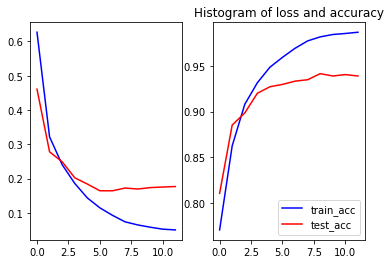

In [ ]:
import pandas as pd
import numpy as np
import random

import joblib
import torch
from torch.utils import data

from sklearn import preprocessing
from sklearn import model_selection

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

from collections import OrderedDict

USE_CUDA = torch.cuda.is_available()
# ====为了让模型实验结果尽可能一致====
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if USE_CUDA:
    torch.cuda.manual_seed(1)


def process_data(data_path):
    # ==== 把csv中单词和标签分开存放 ====
    instances = open(data_path, encoding='unicode_escape').read().strip().split('\n,,\n,,\n')
    # print(instances)
    word = []
    tag = []
    file_num = []

    count = 0
    for i in instances:
        if count < 80:
            count = count + 1
            file_words_tags = i.split('\n')

            for j in file_words_tags:
                file_num.append(j.split(',')[0])
                word.append(j.split(',')[1])
                tag.append(j.split(',')[2])
        else:
            break

    # ==== dataframe ====
    data = {'File#': file_num, 'Word': word, 'Tag': tag}
    df = pd.DataFrame(data=data)
    print("df complete!")
    print(df.head(200))

    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])
    sentence = df.groupby("File#")["Word"].apply(list).values
    tags = df.groupby("File#")["Tag"].apply(list).values

    return sentence, tags, enc_tag


if __name__ == "__main__":
    sentence, tags, enc_tag = process_data(training_file)

    max_len = 0
    for i in sentence:
        if len(i) > max_len:
            max_len = len(i)
    print("FileSentence_max_len", max_len, "File_num", len(sentence))

    # ==== 载入数据 ====
    meta_data = {
        "enc_tag": enc_tag
    }
    joblib.dump(meta_data, "meta.bin")  #

    num_tag = len(list(enc_tag.classes_))  # attributes: classes_  ndarray of shape (n_classes,)

    (
        train_sentences,
        test_sentences,
        train_tag,
        test_tag
    ) = model_selection.train_test_split(sentence, tags, random_state=42, test_size=0.1)

    train_dataset = EntityDataset(
         texts=train_sentences, tags=train_tag, max_len=max_len
    )

    train_data_loader = torch.utils.data.DataLoader(
         train_dataset, batch_size=train_batch_size, num_workers=0
    )
    print("train_data load over!")

    valid_dataset = EntityDataset(
        texts=test_sentences, tags=test_tag, max_len=max_len
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=valid_batch_size, num_workers=0
    )
    print("valid_data load over!")

    # ==== 载入模型 ====
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = EntityModel(num_tag=num_tag)
    model.to(device)
    print("Model load!")

    # ==== 载入engine训练 ====
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train_sentences) / train_batch_size * epochs)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

    best_loss = np.inf
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(epochs):
        train_loss, train_acc = train_fn(train_data_loader, model, optimizer, device, scheduler)
        test_loss, test_acc = eval_fn(valid_data_loader, model, device)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
        print(f"Train Acc = {train_acc} Valid Acc = {test_acc}")
        if test_loss < best_loss:
            torch.save(model.state_dict(), model_path, _use_new_zipfile_serialization=False)
            best_loss = test_loss

    # ==== 画图 ====
    plt.subplot(121)
    epochs = range(len(train_loss_list))
    plt.plot(epochs, train_loss_list, 'b', label='train_loss')
    plt.plot(epochs, test_loss_list, 'r', label='test_loss')

    plt.subplot(122)
    plt.plot(epochs, train_acc_list, 'b', label='train_acc')
    plt.plot(epochs, test_acc_list, 'r', label='test_acc')

    plt.legend()
    plt.title("Histogram of loss and accuracy")

    plt.show()


# Predict

In [ ]:
import numpy as np

import joblib
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


if __name__ == "__main__":

    # meta_data = joblib.load("meta.bin")
    meta_data = joblib.load("/content/drive/MyDrive/Biobert_metabolite_result_weights/80_files_meta.bin")
    enc_tag = meta_data["enc_tag"]

    num_tag = len(list(enc_tag.classes_))  # attributes: classes_  ndarray of shape (n_classes,)

    sentence = '''Glucose-6-phosphate dehydrogenase, 6-phosphogluconate dehydrogenase, glutathione reductase and pyruvate kinase of Candida 
    utilis and baker's yeast, when in anionic form, were adsorbed on a cation exchanger, P-cellulose, due to affinities similar to 
    those for the phosphoric groups of their respective substrates; thus, glucose-6-phosphate dehydrogenase was readily eluted by either 
    or NADPH, glutathione reductase by NADPH, 6-phosphogluconate dehydrogenase by 6-phosphogluconate, and pyruvate kinase by either ATP 
    or ADP. This type of chromatography may be called "affinity-adsorption-elution chromatography"; the main principle is different from 
    that of so-called affinity-elution chromatography. Based on these findings, a large-scale procedure suitable for successive purification 
    of several enzymes having affinities for the phosphoric groups of their substrates was devised. As an example, glucose-6-phosphate 
    dehydrogenase was highly purified from baker's yeast and crystallized.'''


    tokenized_uncode = tokenizer.tokenize(
        sentence,
    )

    tokenized_sentence = tokenizer.encode(
           sentence,
    )

    sentence = sentence.split()
    max_len = len(tokenized_uncode)


    test_dataset = EntityDataset(
       texts=[sentence],
       tags=[[0] * len(sentence)],
       max_len=max_len
    )

    # ==== 载入模型 ====
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if use cpu to run
    model = EntityModel(num_tag=num_tag)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Biobert_metabolite_result_weights/80_files_biobert_appli_model.bin'))
    model.to(device)
    print("Model load!")

    with torch.no_grad():
        data = test_dataset[0]

        for k, v in data.items():
            data[k] = v.to(device).unsqueeze(0)
        tag, _, _, _ = model(**data)

        prediction = enc_tag.inverse_transform(
                tag.argmax(2).cpu().numpy().reshape(-1)
            )[:len(tokenized_sentence)]

        list_pred = []
        for i in tokenized_uncode:
            list_pred.append(str(i))
        list_pred = [101] + list_pred + [102]
        print(list_pred)
        pred_dic = {}
        for i in range(len(prediction)):
            pred_dic[list_pred[i]] = prediction[i]
        print(pred_dic)

# ==== NER模型分词及权重导入参考https://github.com/abhi1thakur/bert-sentiment及https://towardsdatascience.com/tagging-genes-and-proteins-with-biobert-c7b04fc6eb4f ====

Model load!
[101, 'glucose', '-', '6', '-', 'phosphate', 'de', '##hy', '##dr', '##ogen', '##ase', ',', '6', '-', 'p', '##hos', '##ph', '##og', '##lu', '##cona', '##te', 'de', '##hy', '##dr', '##ogen', '##ase', ',', 'g', '##lut', '##ath', '##ione', 'red', '##uc', '##tase', 'and', 'p', '##yr', '##u', '##vate', 'kinase', 'of', 'can', '##di', '##da', 'u', '##til', '##is', 'and', 'b', '##aker', "'", 's', 'yeast', ',', 'when', 'in', 'an', '##ion', '##ic', 'form', ',', 'were', 'ads', '##or', '##bed', 'on', 'a', 'cat', '##ion', 'exchange', '##r', ',', 'p', '-', 'cell', '##ulos', '##e', ',', 'due', 'to', 'a', '##ffin', '##ities', 'similar', 'to', 'those', 'for', 'the', 'p', '##hos', '##ph', '##ori', '##c', 'groups', 'of', 'their', 'respective', 'substrates', ';', 'thus', ',', 'glucose', '-', '6', '-', 'phosphate', 'de', '##hy', '##dr', '##ogen', '##ase', 'was', 'readily', 'el', '##uted', 'by', 'either', 'or', 'na', '##d', '##ph', ',', 'g', '##lut', '##ath', '##ione', 'red', '##uc', '##tase', 'b

# Confusion Matrix - onefile

Test data load over!


Some weights of the model checkpoint at /content/biobert_v1.1_pubmed were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model load!
Confusion matrix, without normalization
[[  0   0   5]
 [  5  80   3]
 [  2   9 166]]


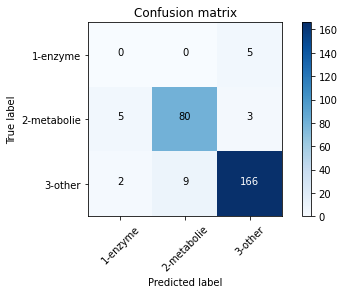

In [10]:
import numpy as np
import itertools

import joblib
import torch
from torch.utils import data
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

from sklearn.metrics import confusion_matrix  # y_true = [,...,]  y_pred = [, ... ,]

USE_CUDA = torch.cuda.is_available()
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if USE_CUDA:
    torch.cuda.manual_seed(1)

# ==== 读取数据 ====
def process_data(data_path, enc_tag):
    # ==== 把tsv中单词和标签分开存放 ====
    instances = open(data_path).read().strip().split('\n,,\n,,\n')

    word = []
    tag = []
    file_num = []

    count = 0
    for i in instances:
      count = count + 1
      if count == 1:  
          file_words_tags = i.split('\n')
          for j in file_words_tags:
              file_num.append(j.split(',')[0])
              word.append(j.split(',')[1])
              tag.append(j.split(',')[2])
      else:
          break  # ==== 句子不能过长…… ===='

    return word, tag


if __name__ == "__main__":
    meta_data = joblib.load("/content/drive/MyDrive/Biobert_metabolite_result_weights/80_files_meta.bin")
    # meta_data = joblib.load("/content/meta.bin")
    enc_tag = meta_data["enc_tag"]
    num_tag = len(list(enc_tag.classes_))

    # ==== 加载测试集 ====
    # word, tags = process_data('/content/testing_metabolite_sep_check_one_file.csv', enc_tag)
    word, tags = process_data('/content/testing_metabolite_sep_check_file_296.csv', enc_tag)

    if "enzyme" not in tags:
      tags.append("enzyme")
      word.append("glucoamylase")
    if "metabolite" not in tags:
      tags.append("metabolite")
      word.append("glucose")
    target_tags = enc_tag.fit_transform(tags)


    string = " ".join(word)


    tokenized_sentence = tokenizer.encode(
           string,
    )

    max_len = len(tokenized_sentence)

    test_dataset = EntityDataset(
         texts=[word], tags=[[0] * len(word)], max_len=max_len
    )

    print('Test data load over!')


    # ==== 载入模型 ====
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # if use cpu to run
    model = EntityModel(num_tag=num_tag)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Biobert_metabolite_result_weights/80_files_biobert_appli_model.bin'))
    # model.load_state_dict(torch.load('/content/biobert_appli_model.bin'))
    model.to(device)
    print("Model load!")

    with torch.no_grad():
        data = test_dataset[0]
        for k, v in data.items():
            data[k] = v.to(device).unsqueeze(0)
        tag, _, _, _= model(**data)
        prediction = enc_tag.inverse_transform(
                tag.argmax(2).cpu().numpy().reshape(-1)
            )
        pred = tag.argmax(2).cpu().numpy().reshape(-1)[:len(tokenized_sentence)]

      
    # ==== target_tags ====
    true_tags = list(target_tags)
    target_tags = []
    for i, s in enumerate(word):
        inputs = tokenizer.encode(
                s,
                add_special_tokens=False
            )
        input_len = len(inputs)
        target_tags.extend([true_tags[i]] * input_len)

    target_tags = target_tags[:max_len - 2]
    target_tags = [2] + target_tags + [2]

    # ==== 0: enzymes, 1:metabolite, 2: other ====
    y_true = []
    y_pred = []
    for m in pred:
      if m == 2:
        y_pred.append('other')
      if m == 1:
        y_pred.append('metabolite')
      if m == 0:
        y_pred.append('enzyme')
    for n in target_tags:
      if str(n) == '2':
        y_true.append('other')
        # count_others = count_others+1
      if str(n) == '1':
        y_true.append('metabolite')
      if str(n) == '0':
        y_true.append('enzyme')
    # print(count_others)

    # confusion_mat = confusion_matrix(y_true, y_pred, labels=["enzyme", "metabolite", "other"]) # 这里顺序不能错，0、1、2
    confusion_mat = confusion_matrix(target_tags, pred, labels=[0, 1, 2])

    # ==== 混淆矩阵画图 参看https://deeplizard.com/learn/video/0LhiS6yu2qQ====
    cm = confusion_mat
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')

      print(cm)
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation=45)
      plt.yticks(tick_marks, classes)

      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2.
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
    
    classes = ['1-enzyme', '2-metabolie', '3-other']
    plot_confusion_matrix(cm, classes)